<a href="https://colab.research.google.com/github/kgpark88/ai-summary/blob/main/energy_efficiency_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 출처 : https://www.kaggle.com/datasets/winternguyen/energy-efficiency-on-buildings/code

<a href="https://ibb.co/tc0YwXc"><img src="https://i.ibb.co/3WxS5zW/Energy-Efficiency-Buildings.jpg" alt="Energy-Efficiency-Buildings" border="0"></a>

### 건물 에너지 소비는 전체 에너지 사용의 약 40%를 차지합니다.
### 설계 단계에서 건물의 냉난방 부하를 예측하는 것은 에너지 효율화를 위해 매우 중요합니다.
### 건물 에너지 성능에 대한 데이터셋을 기반으로 건물의 냉난방 부하를 예측하기 위해 다양한 모델을 적용합니다.

#### Input
- relative compactness : 건물과 동일한 부피를 갖는 가상 입방체의 표면적에 대한 건물 외피의 표면적의 비율.  relative compactness가 높은 건물은 더 컴팩트한 모양을 가지므로 에너지가 손실될 수 있는 건물 외피의 표면적을 최소화하여 에너지 소비를 줄이는 데 도움이 될 수 있음
- roof area
- overall height
- surface area
- glazing area : 투명하거나 반투명한 건물외피재료 면적
- wall area
- glazing area distribution of a building
- orientation.

#### Output
- 난방부하
- 냉방부하


In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 1. 소개
- 건물에서 열에너지는 냉방부하(CL)와 난방부하(HL)의 두 가지 측정을 포함하며 이러한 측정은 난방 환기 및 공조(HVAC) 시스템에 의해 규제됩니다.
- HVAC 시스템은 공간의 HL과 CL을 계산하여 원하는 실내 공기 상태를 제공하도록 설계되었습니다.
- 필요한 냉·난방 용량은 주로 건물 특성, 유형, 기후 조건을 포함한 기본 요소에 따라 산정됩니다.
- 건물에너지성능을 적절하게 검토하고 HVAC 시스템을 최적으로 설계함으로써 보다 지속 가능한 에너지 소비를 보장할 수 있습니다


# 2. 데이터 준비

- 원 데이터셋 : https://archive.ics.uci.edu/ml/datasets/Energy+efficiency
- 사용 데이터셋 : https://www.kaggle.com/datasets/winternguyen/energy-efficiency-on-buildings

In [19]:
# data = pd.read_csv('Building Energy Efficiency.csv')
data = pd.read_csv('https://raw.githubusercontent.com/kgpark88/energy-bigdata-analysis/main/building_energy_efficiency.csv')

In [20]:
data.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.7638,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.9800,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.9800,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.9800,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.9000,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


# Variable(s) Information:

+ Relative Compactness
+ Surface Area - m²
+ Wall Area - m²
+ Roof Area - m²
+ Overall Height - m
+ Orientation - 2:North, 3:East, 4:South, 5:West
+ Glazing Area - 0%, 10%, 25%, 40% (of floor area)
+ Glazing Area Distribution (Variance) - 1:Uniform, 2:North, 3:East, 4:South, 5:West
+ Heating Load - kWh
+ Cooling Load - kWh  
  

In [21]:
data.shape

(768, 10)

In [22]:
data.isnull().sum()

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
dtype: int64

각 데이터의 분포 체크

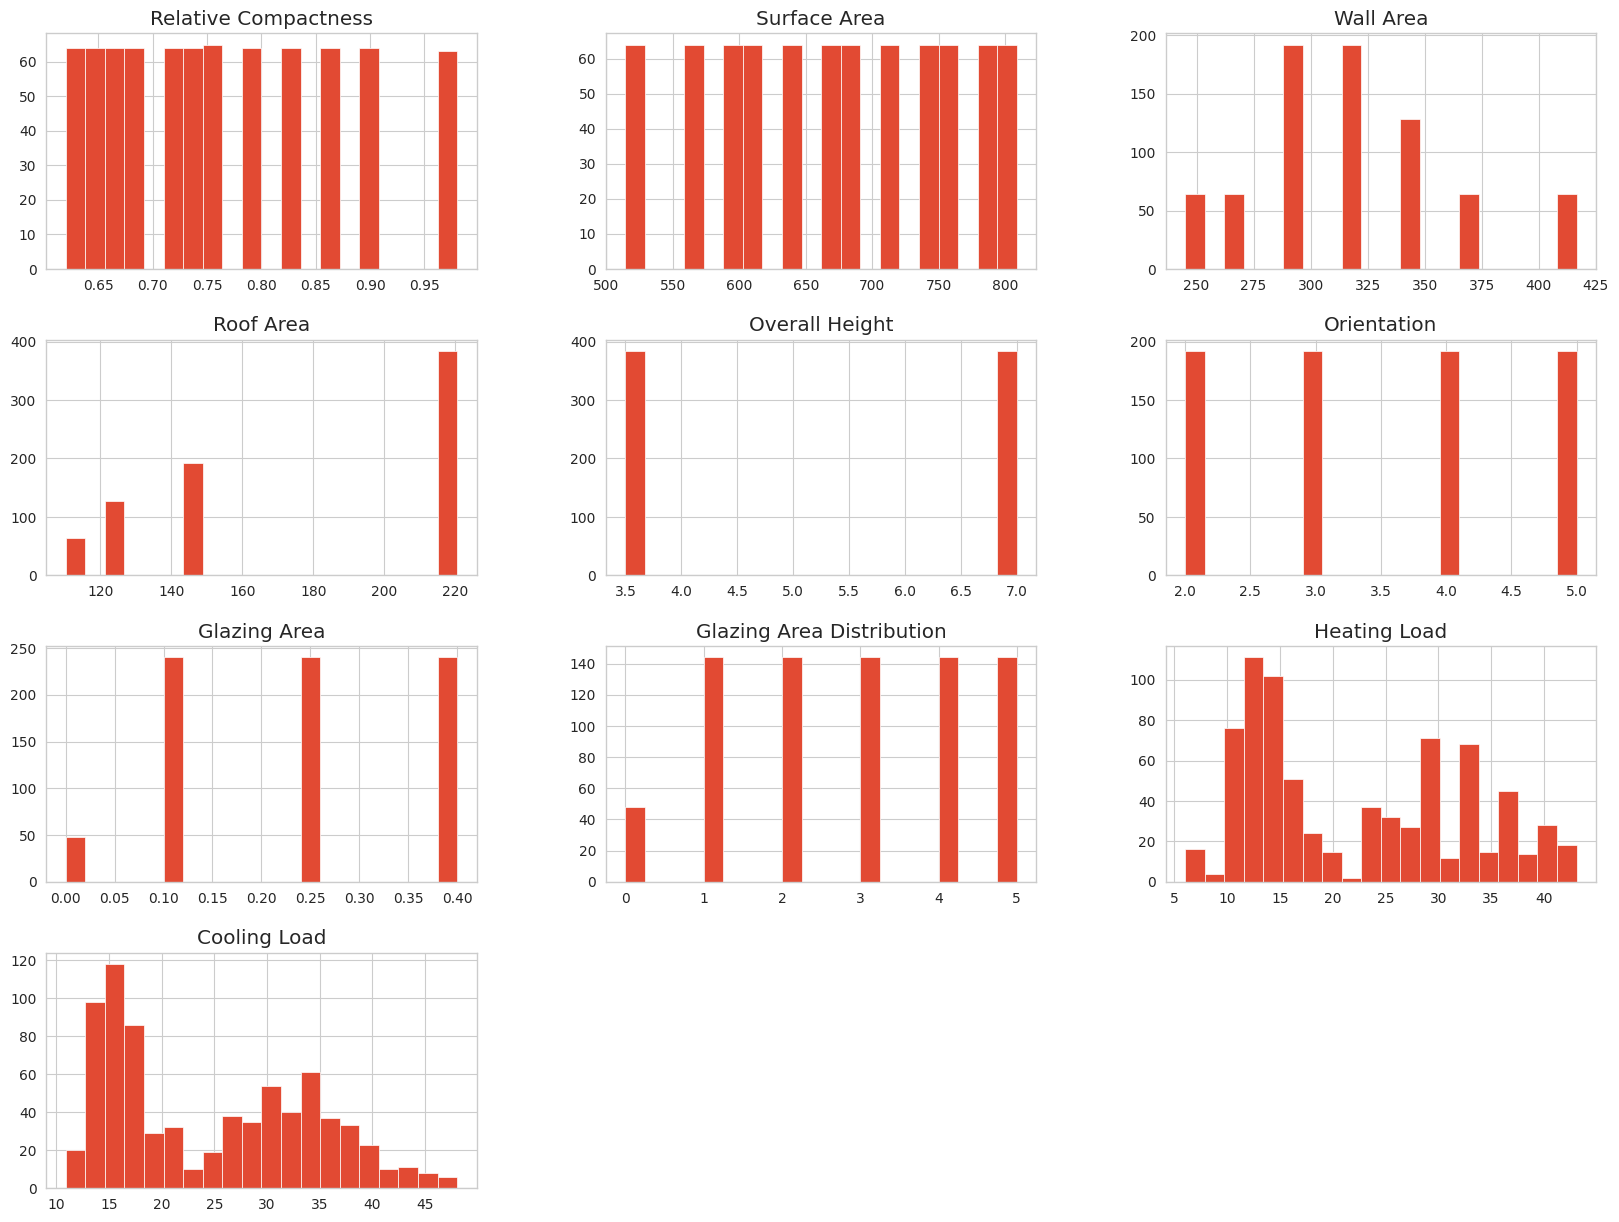

In [23]:
data.hist(bins=20, figsize=(20,15))
plt.show()

상관관계 분석

In [24]:
import plotly.express as px

yprop = 'Surface Area'
xprop = 'Cooling Load'
h= None
px.scatter(data, x=xprop, y=yprop, color=h, marginal_y="violin", marginal_x="box", trendline="ols", template="simple_white")

In [25]:
import plotly.express as px
yprop = 'Overall Height'
xprop = 'Heating Load'
h= None
px.scatter(data, x=xprop, y=yprop, color=h, marginal_y="violin", marginal_x="box", trendline="ols", template="simple_white")

명확한 상관관계를 찾기위해 상관관계 행렬 확인

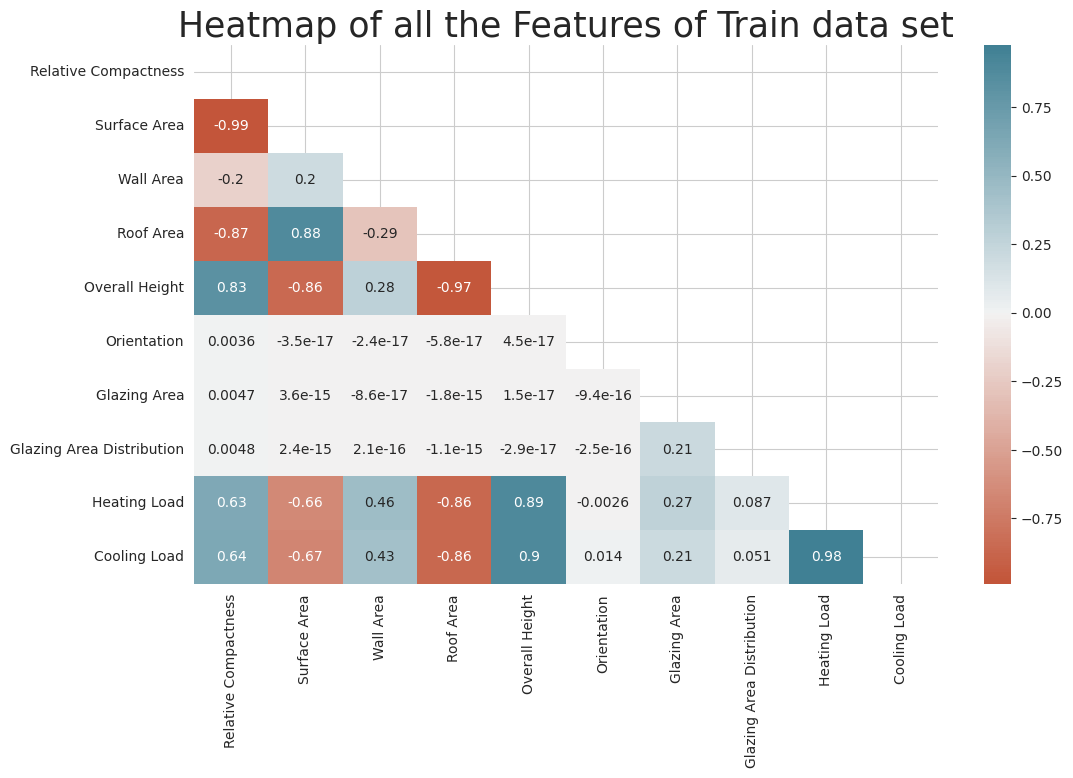

In [26]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
style.use('ggplot')
sns.set_style('whitegrid')

plt.subplots(figsize = (12,7))
## Plotting heatmap. # Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
plt.title("Heatmap of all the Features of Train data set", fontsize = 25);

### 데이터 분리작업

In [27]:
!pip install catboost

In [28]:
from scipy.stats import randint as sp_randint
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense
from keras.models import Sequential
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

In [29]:
X = data[['Relative Compactness', 'Surface Area', 'Wall Area',
          'Roof Area', 'Overall Height', 'Orientation',
          'Glazing Area', 'Glazing Area Distribution']]
Y = data[['Heating Load', 'Cooling Load']]
Y1= data[['Heating Load']]
Y2= data[['Cooling Load']]

- 데이터 세트를 훈련 및 테스트 세트로 분할.
- 특징 스케일링 또는 데이터 정규화는 데이터의 독립 변수   
  또는 특징의 범위를 정규화하는 데 사용되는 방법입니다.
- 따라서 독립 변수에서 값이 많이 다를 때 모든 값이   
  비교 가능한 범위에 유지되도록 특성 스케일링을 사용합니다.

In [30]:
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X, Y1, Y2, test_size=0.33, random_state = 20)

MinMax = MinMaxScaler(feature_range= (0,1))
X_train = MinMax.fit_transform(X_train)
X_test = MinMax.transform(X_test)

# 모델링

각 모델의 결과를 저장할 DataFrame을 만듭니다.

In [31]:
accuracy = pd.DataFrame(index=None, columns=['model',
                                        'train_Heating','test_Heating',
                                        'train_Cooling','test_Cooling'])

In [32]:
regressors = [['SVR',SVR()],
              ['DecisionTreeRegressor',DecisionTreeRegressor()],
              ['KNeighborsRegressor', KNeighborsRegressor()],
              ['RandomForestRegressor', RandomForestRegressor()],
              ['MLPRegressor',MLPRegressor()],
              ['AdaBoostRegressor',AdaBoostRegressor()],
              ['GradientBoostingRegressor',GradientBoostingRegressor()]]

In [33]:
for r in regressors:
    name = r[0]
    model = r[1]

    model.fit(X_train, y1_train)
    actr1 = r2_score(y1_train, model.predict(X_train))
    acte1 = r2_score(y1_test, model.predict(X_test))

    model.fit(X_train, y2_train)
    actr2 = r2_score(y2_train, model.predict(X_train))
    acte2 = r2_score(y2_test, model.predict(X_test))

    accuracy = accuracy.append(pd.Series({'model':name, 'train_Heating':actr1,
                               'test_Heating':acte1,'train_Cooling':actr2,
                               'test_Cooling':acte2}),ignore_index=True )

accuracy.sort_values(by='test_Cooling')

,model,train_Heating,test_Heating,train_Cooling,test_Cooling
4,MLPRegressor,0.885245,0.889480,0.797618,0.821830
0,SVR,0.930662,0.910593,0.892578,0.887385
2,KNeighborsRegressor,0.945989,0.904490,0.926869,0.888896
5,AdaBoostRegressor,0.970233,0.966553,0.941772,0.942984
1,DecisionTreeRegressor,1.000000,0.997137,1.000000,0.950264
3,RandomForestRegressor,0.999390,0.997159,0.995534,0.964786
6,GradientBoostingRegressor,0.998173,0.997641,0.979423,0.976044


# 모델 파라미터 튜닝
- Boosting machine learning 알고리즘은 단순한 알고리즘보다   
더 나은 정확도를 제공하기 때문에 많이 사용됩니다.
- 알고리즘의 성능은 하이퍼파라미터에 따라 다릅니다.
- 최적의 parameter는 더 높은 정확도를 달성하는 데 도움이 될 수 있습니다.
- 수동으로 hyper parameter를 찾는 것은 지루하고 계산 비용이 많이 듭니다.
-  하이퍼파라미터 튜닝의 자동화가 중요합니다.
- RandomSearch, GridSearchCV, Bayesian optimization은 하이퍼파라미터를   
최적화하는 데 사용됩니다.

* 결정계수(R-Squared)의 의미 : https://m.blog.naver.com/tlrror9496/222055889079

In [34]:
param_grid = [{"learning_rate": [0.01, 0.02, 0.1],
               "n_estimators":[150, 200, 250], "max_depth": [4, 5, 6],
               "min_samples_split":[1, 2, 3], "min_samples_leaf":[2, 3],
               "subsample":[1.0, 2.0]}]

gb = GradientBoostingRegressor()
gs_gb = GridSearchCV(gb, param_grid, cv=10,
                    scoring='neg_mean_squared_error')
gs_gb.fit(X_train, y2_train)

print("R-Squared : {}".format(gs_gb.best_score_))
print(f"Best Hyperparameters : \n{gs_gb.best_params_}"))

R-Squared::-1.118438361289747
Best Hyperparameters::
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 250, 'subsample': 1.0}


# A. Decision Tree Regressor parameters turning

In [35]:
dt = DecisionTreeRegressor()
param_grid = {"criterion": ["squared_error", "absolute_error"],"min_samples_split": [15, 16, 17, 18],
              "max_depth": [5, 6, 7],"min_samples_leaf": [4, 5, 6],
              "max_leaf_nodes": [29, 30, 31, 32],}

gs_dt = GridSearchCV(dt, param_grid, cv=5)

gs_dt.fit(X_train, y2_train)
print(f"R-Squared : {gs_dt.best_score_}")
print(f"Best Hyperparameters : \n{gs_dt.best_params_}")

R-Squared::0.9598997619174842
Best Hyperparameters::
{'criterion': 'squared_error', 'max_depth': 6, 'max_leaf_nodes': 31, 'min_samples_leaf': 5, 'min_samples_split': 17}


In [38]:
dt = DecisionTreeRegressor(criterion='squared_error', max_depth=6, max_leaf_nodes=32, min_samples_leaf= 5, min_samples_split=17)

dt.fit(X_train,y1_train)
print("R-Squared on train dataset={}".format(dt.score(X_test,y1_test)))

dt.fit(X_train,y2_train)
print("R-Squaredon test dataset={}".format(dt.score(X_test,y2_test)))

R-Squared on train dataset=0.9953559923756888
R-Squaredon test dataset=0.9592409931240967


# B. Tune Random Forests Parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators': [350, 400, 450], 'max_features': [1, 2],
               'max_depth': [85, 90, 95]}]

rf = RandomForestRegressor(n_jobs=-1)
gs_rf = GridSearchCV(rf, param_grid, cv=10,
                    scoring='neg_mean_squared_error')
gs_rf.fit(X_train, y2_train)

print("R-Squared::{}".format(gs_rf.best_score_))
print("Best Hyperparameters::\n{}".format(gs_rf.best_params_))

In [ ]:
rf = RandomForestRegressor(n_estimators=250, max_features=1, max_depth=90, bootstrap=True)

rf.fit(X_train,y1_train)
print("R-Squared on train dataset={}".format(rf.score(X_test,y1_test)))

rf.fit(X_train,y2_train)
print(f"R-Squaredon test dataset={rf.score(X_test,y2_test)}")

# C. Gradient Boosting Regression - Hyperparameter Tuning

In [ ]:
gbr = GradientBoostingRegressor(learning_rate=0.1,n_estimators=250,
                                max_depth=5, min_samples_split=3,
                                min_samples_leaf=2, subsample=1.0)

gbr.fit(X_train,y1_train)
print(f"R-Squared on train dataset={gbr.score(X_test,y1_test)}")

gbr.fit(X_train,y2_train)
print(f"R-Squaredon test dataset={gbr.score(X_test,y2_test)}")

# D. CatBoostRegressor
- "CatBoost"라는 이름은 "Category"와 "Boosting"이라는 두 단어에서 유래했습니다.
- 참고 : https://velog.io/@tjddls321/CatBoost


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

cb = CatBoostRegressor()
parameters = {'depth':[8, 10],'iterations':[10000],'learning_rate':[0.02,0.03],
              'border_count':[5],'random_state': [42, 45]}

gs_cb = GridSearchCV(estimator=cb, param_grid = parameters, cv = 2, n_jobs=-1)
gs_cb.fit(X_train, y2_train)
print("Results from Grid Search" )
print(f"\n The best estimator across ALL searched params:\n{gs_cb.best_estimator_}")
print(f"\n The best score across ALL searched params:\n{gs_cb.best_score_}")
print(f"\n The best parameters across ALL searched params:\n{gs_cb.best_params_}")

In [ ]:
print(f"Best Hyperparameters::\n {gs_CBR.best_params_}")

# 모델 성능 Summary

In [ ]:
Acc1 = pd.DataFrame(index=None, columns=['model','train_Heating','test_Heating',
                                         'train_Cooling','test_Cooling'])

In [ ]:
regressors = [
    [
        "DecisionTreeRegressor",
        DecisionTreeRegressor(
            criterion="squared_error",max_depth=6,max_leaf_nodes=31,
            min_samples_leaf=5,min_samples_split=17,
        ),
    ],
    [
        "RandomForestRegressor",
        RandomForestRegressor(
            n_estimators=350, max_features=1, max_depth=90, bootstrap=True
        ),
    ],
    [
        "GradientBoostingRegressor",
        GradientBoostingRegressor(
            learning_rate=0.1, n_estimators=250, max_depth=5,
            min_samples_split=2, min_samples_leaf=3, subsample=1.0,
        ),
    ],
    [
        "CatBoostRegressor",
        CatBoostRegressor(
            border_count=5, depth=10, iterations=10000,
            learning_rate=0.02, random_state=42
        ),
    ],
]


In [ ]:
for r in regressors:
    name = r[0]
    model = r[1]

    model.fit(X_train,y1_train)
    actr1 = r2_score(y1_train, model.predict(X_train))
    acte1 = r2_score(y1_test, model.predict(X_test))

    model.fit(X_train,y2_train)
    actr2 = r2_score(y2_train, model.predict(X_train))
    acte2 = r2_score(y2_test, model.predict(X_test))

    Acc1 = Acc1.append(pd.Series({'model':name, 'train_Heating':actr1,
                                  'test_Heating':acte1,'train_Cooling':actr2,
                                  'test_Cooling':acte2}),ignore_index=True )
Acc1.sort_values(by='test_Cooling')

# 3. 결론
- 난방 및 냉방 부하를 예측하기 위해 다양한 모델을 사용하여 건물 에너지 성능을 예측 했습니다.
- 모델에서 다양한 parameter를 조정하여 매우 좋은 예측 결과를 얻었습니다.
- 난방 및 냉방 부하 모두에서 >99.5%, 실험 데이터 세트와 비교

In [ ]:
model = CatBoostRegressor(border_count=5, depth=10, iterations=10000,
                          learning_rate=0.02, random_state=42)
model.fit(X_train,y1_train)
actr1 = r2_score(y1_train, model.predict(X_train))
acte1 = r2_score(y1_test, model.predict(X_test))
y1_pred = model.predict(X_test)

model.fit(X_train,y2_train)
actr2 = r2_score(y2_train, model.predict(X_train))
acte2 = r2_score(y2_test, model.predict(X_test))
y2_pred = model.predict(X_test)

In [ ]:
print("CatBoostRegressor: R-Squared on train dataset={}".format(actr1))
print("CatBoostRegressor: R-Squared on test dataset={}".format(acte1))
print("CatBoostRegressor: R-Squared on train dataset={}".format(actr2))
print("CatBoostRegressor: R-Squared on test dataset={}".format(acte2))

In [ ]:
x_ax = range(len(y1_test))
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(x_ax, y1_test, label="Actual Heating")
plt.plot(x_ax, y1_pred, label="Predicted Heating")
plt.title("Heating test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Heating load(kW)')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(x_ax, y2_test, label="Actual Cooling")
plt.plot(x_ax, y2_pred, label="Predicted Cooling")
plt.title("Coolong test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Cooling load(kW)')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)

plt.show()

In [ ]:
def calculate_error_rate(y1_test, y1_pred):
    error_rate=[]
    for i in range(len(y1_pred)):
        error_rate.append((y1_pred[i] - y1_test.values[i])/y1_test.values[i]*100)
    return error_rate

x_ax = range(len(y1_test))
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(x_ax, calculate_error_rate(y1_test, y1_pred),
         label="Relative deviation obtained on Heating load")
plt.title("Heating load")
plt.xlabel('X-axis')
plt.ylabel('Error(%)')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(x_ax, erros(y2_test, y2_pred), label="Relative deviation obtained on Cooling load")
plt.title("Cooling load")
plt.xlabel('X-axis')
plt.ylabel('Error(%)')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)

plt.show()